# Evolutionary Algorithms: Painting with Polygons
---
[Evolutionary algorithms](https://en.wikipedia.org/wiki/Evolutionary_algorithm) are a family of algorithms that are inspired in natural evolution processes in order to reach a solution of a particular [optimization problem](https://en.wikipedia.org/wiki/Optimization_problem). Such algorithms typically use concepts such as random mutations, reproduction, and selection to incrementally find better solutions. The general idea is that after having formulated our problem, which can consist for example on minimising certain [loss function](https://en.wikipedia.org/wiki/Loss_function), and proposing several starting solutions, we let the algorithm work on these solutions and making them evolve. After some time, the solutions will have changed significantly and only the fittest, the ones that score better according to our problem formulation, will survive. Eventually, the algorithm will stop and the solutions will have improved. This kind of programming is used for tackling problems in a wide range of fields suchs as mathematics, engineering, economics and [many more](https://en.wikipedia.org/wiki/List_of_genetic_algorithm_applications). Famous applications of evolutionary algorithms are one type of [antenna](https://en.wikipedia.org/wiki/Evolved_antenna) NASA used in some satellites, [virtual creatures](https://www.karlsims.com/evolved-virtual-creatures.html) that learn to behave like animals in a simulated world, or the [best ever Super Mario World player](https://www.youtube.com/watch?v=qv6UVOQ0F44).

The example we are going to see in this lab is related to art, specifically to [generative art](https://en.wikipedia.org/wiki/Generative_art). In particular we are going to recreate Roger Johansson's project [Evolution of Mona Lisa](https://rogerjohansson.blog/2008/12/11/genetic-gallery/) that consist in reproducing famous paintings with a collage of polygons of different shapes and colours. Fortunately, many others, inspired by the same amazing project, have coded useful interactive applets, [here](https://alteredqualia.com/visualization/evolve/) and [here](https://chriscummins.cc/s/genetics/), that we can check out during our programming journey. By the end of the lab you will know how to do the same thing in Python, and with any image you want to input.  

## Problem formulation
---

The basics of this laboratory is to be able to manipulate images within Python. Implementing the evolutionary algorithms will depend a lot on how the images are processed and polygons painted. A digital image is at the end a big matrix - depending on the size and resolution - with a set of numbers that define the colour of each pixel. Manipulating images is therefore nothing else than performing mathematical operations that change those pixel values. Operations like drawing a circle on top of a picture or balancing whites can be performed by python code, but it translates to pixel-by-pixel complex mathematical operations. Fortunately, thanks to libraries like [Pillow](https://pillow.readthedocs.io/en/stable/), also known as `PIL`, we can use handy objects such as `Image` and `ImageDraw` that make working with images a relatively simple task.

The first thing we will do is to create a function that draws a collection of polygons, the building blocks of this exercise. The main input to the function will be a list of elements (polygons) where each element is a Pyhton dictionary with two attributes; `vertices` and `RGBA`. `vertices` is itself a list of points in a two-dimensional space that denote each of the vertices of the polygon (the order is important). Thus, if we have lists of 3 vertices we will be drawing triangles. Remember that when processing and rendering images, the X values increase from left to right, but Y values increase from top to bottom. The other attribute, `RGBA`, is a tuple with integer values from 0 to 255 for each of the [Red, Green and Blue channels](https://en.wikipedia.org/wiki/RGB_color_model) plus the Alpha channel for the transparency. The values `(0,0,0,255)` would represent the colour black, `(255,255,255,255)` would be white, and `(0,0,255,125)` would be a semitransparent blue. Finally, we also need to provide the width and height of the canvas in a variable called `size`.

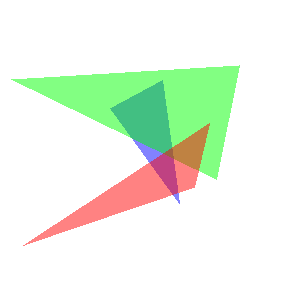

In [21]:
from PIL import Image, ImageDraw

polygons = [{'vertices': [(179, 203), (162, 80), (110, 108)], 'RGBA': (0, 0, 255, 125)},
{'vertices': [(239, 65), (216, 179), (11, 79)], 'RGBA': (0, 255, 0, 125)},
{'vertices': [(209, 123), (23, 245), (194, 187)], 'RGBA': (255, 0, 0, 125)}]

def draw(polygons, size):
    """ Draws the collection of polygons in a canvas. """

    # Draw the canvas in white
    img = Image.new('RGB', (size[0], size[1]), (255, 255, 255))
    drw = ImageDraw.Draw(img, 'RGBA')

    # Draw each polygon
    for pol in polygons:
        drw.polygon(pol["vertices"], pol["RGBA"])

    return(img.convert("RGB"))


draw(polygons, size=(300,300))

The result is a white background image with the three polygons. Notice that the overlapping of semi-transparent polygons also create regions with different colours.

The next step is to create a function that generates a collection of `N` triangles with their vertices placed at random over the canvas of a certain `size`. By default we generate the initial colours randomly as well as the transparency, however we allow for certain customization of the initial state with, for example, all triangles being black with a specific value for transparency.  

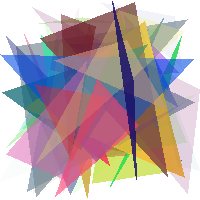

In [22]:
import numpy as np

def random_triangles(N, size, colour="random", alpha="random"):
    """ Generates a population of random triangles. """

    collection = []

    for i in range(N):
        # Generate vertex coordinates
        coords = [ (np.random.randint(0, size[0]), np.random.randint(0, size[1])) for i in range(3)]

        # Generate alpha
        if alpha == "random":
            a = np.random.randint(0, 256)
        else:
            a = alpha

        # Generate colour
        if colour == "white":
            rgba = (255,255,255,a)
        elif colour == "black":
            rgba = (0, 0, 0, a)
        elif colour == "random":
            rgba = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256), a)

        triangle = {"vertices": coords, "RGBA": rgba}
        collection.append(triangle)

    return(collection)

# Generate a collection of random triangles
collection = random_triangles(N=50, size=(200,200), colour="random", alpha="random")
# Draw the triangles
img = draw(collection, size=(200,200))
img

Great! Now we know how to create a collection of triangles and generate an image of it. But we also need load into the program the image that we want to reproduce. Again, pillow library makes our lives easy, `Image.open()` does just that if we provide the local path of the png file. We also convert it to RBG format, This ensures that both the target image and the result of the `draw()` function - which we also convert to RGB - have exactly the same format.

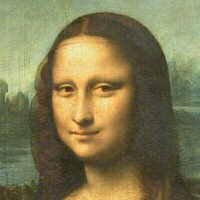

In [27]:
# Read image
image_path = "monalisa.png"
# Open the image and convert it to RGB (no alpha channel)
target = Image.open(image_path).convert("RGB")
target

One useful image manipulation trick is to subtract one image from the other using `ImageChops.difference()` function. Remember, this is just mathematically subtracting pixel values from two matrices. The result is a matrix with the difference values, which in turn is also an image that we can display.

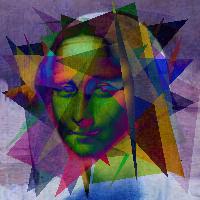

In [28]:
from PIL import ImageChops

ImageChops.difference(img, target)

But more interestingly, we can create a function that, using the same principle, returns the pixel-by-pixel difference between the triangles image and the target. `ImageChops.difference()` provides already the absolute difference for each RGB channel and for each pixel. Using the `.getdata()` attribute returns this as values in a matrix. Then, we can just sum all the elements with `.sum()`.   

In [29]:
# Compute pixel difference
def pixel_difference(candidate,target):
    """ Computes the image difference pixel by pixel"""
    diff = ImageChops.difference(candidate, target)
    totdiff = np.array(diff.getdata()).sum()
    return(totdiff)

diff = pixel_difference(img,target)
diff

np.int64(10651737)

The result is how far apart these two images are in all 3 RGB channels. Of course the bigger the image is or the more resolution we have, the higher the difference will be. Ideally, we want to construct a measure that does not depend on that. Because we start by default with a white empty canvas, one solution consists on considering the difference between a white image and the target as the maximum difference. This allows us to construct a fitness measure in terms of this maximum difference. Thus, 0% would be the initial empty canvas, and 100% would be the exact replication.

In [30]:
# Compute maximum pixel difference
def max_pixel_difference(target):
    """ Computes the maximum pixel difference from white canvas"""
    white = Image.new('RGB', target.size, (255, 255, 255))
    diff = ImageChops.difference(white, target)
    maxdiff = np.array(diff.getdata()).sum()
    return(maxdiff)

maxdiff = max_pixel_difference(target)
fitness = (1 - diff / maxdiff) * 100
print("Fitness = " + str(np.round(fitness,4)) + "%")

Fitness = 38.7815%


Expressing the fitness as similarity percentage allows us to compare quantitatively which two triangle collection is closer to the target image.

<div class="alert alert-block alert-info"><b>Exercise 1:</b><br> Create a new function called random_polygon() that generates a polygon, instead of triangles, with a number of vertices controlled by a parameter named "vnum". Then, use the function to create a collection of 3 polygons with 5 vertices and plot them on a white canvas to show that the code works correctly.</div>

In [ ]:
### EXERCISE 1 SOLUTION ###



## Hill Climbing
---

Now that we have the building blocks ready, it's time to implement the evolutionary algorithms that will make our collection of polygons evolve and become more and more similar to the target image. [Hill Climbing](https://en.wikipedia.org/wiki/Hill_climbing) is probably the most simple one we can start with. The application of this algorithm in our problem consists in introducing a mutation in our collection of triangles, then keep or discard the new mutated collection depending on whether the overall fitness has increased or decreased.

A mutation is a relatively small change in the vertex coordinates or the colour of one of the triangles. As the iterations progress, more beneficial mutations - those that increase the fitness - cumulate and allow this incremental transformation to take place. The mutations can also be of different types; [This example](https://alteredqualia.com/visualization/evolve/) allows the user to select between "soft", "medium" and "hard" mutations. As you will explore in the Exercise 2, this has naturally some impact on the evolution path. For the moment we will only implement the "hard" mutation that consist on replacing randomly one of the vertices and changing randomly the color of the triangle including its transparency.

As mentioned before, each of triangles in our collection is a python dictionary. There is one caveat we should consider when performing the mutation. We want to return a mutated collection object as a different object than the original. Therefore we will first copy the original collection into a new one and then perform the mutation on this new copy and return that as a new object. When copying the original list, if we did something like `mutant=original`, we would be doing a [shallow copy](https://www.programiz.com/python-programming/shallow-deep-copy) rather than a deep copy. Any changes to the `mutant` object would also affect the `original` object. In order to avoid this issue we use the function `deepcopy()` from the `copy` library.    

(-0.5, 199.5, 199.5, -0.5)

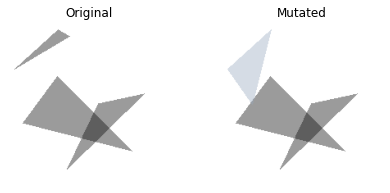

In [ ]:
import copy
import matplotlib.pyplot as plt

def mutation(original, size, mtype="hard"):
    """
    Produces a mutation within a collection.

    The mutation can be "Soft", "Medium", "Hard" or as described in this page
    (https://alteredqualia.com/visualization/evolve/)
    """
    # Produce a deep copy instead of modifying the original
    mutant = copy.deepcopy(original)

    # Randomly selecting the index of polygon to mutate
    polidx = np.random.randint(len(mutant))

    if mtype == "soft":
        # Implementing soft mutation is part of the exercise 2
        pass
    elif mtype == "medium":
        # Implementing medium mutation is part of the exercise 2
        pass
    elif mtype == "hard":
        # Randomly change the color and transparency
        mutant[polidx]["RGBA"] = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))

        # Replace one of the vertex or random values
        vtidx = np.random.randint(len(mutant[polidx]["vertices"]))
        mutant[polidx]["vertices"][vtidx] = (np.random.randint(0, size[0]), np.random.randint(0, size[1]))

    else:
        # Raise an error if non of the above
        raise ValueError("Wrong value for mtype")

    return(mutant)

# Create a collection of black semi-transparent triangles
collection = random_triangles(N=3, size=(200,200), colour="black", alpha=100)
# Render the initial collection
original_img = draw(collection, size=(200,200))
# Mutate the original collection
new_collection = mutation(collection, size=(200,200), mtype="hard")
# Render the new mutant image
mutated_img = draw(new_collection, size=(200,200))

# Plot the original and mutated images side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
ax[0].imshow(original_img);
ax[0].set_title("Original")
ax[0].axis('off')
ax[1].imshow(mutated_img);
ax[1].set_title("Mutated")
ax[1].axis('off')

The effect of the "hard mutation" is pretty clear if we use a small initial set of black triangles. Only one triangle changes colour and one vertex from it moves somewhere else, the rest stays the same.

Let's now design the function `triangle_painting_hill_climbing()` that will run the whole process. The main arguments are the target image, the number of triangles of the collection, the maximum number of iterations we want to run the code for and the type of mutation, which is set to "hard" by default. As for the general structure, is rather simple. We start generating a random collection of triangles, whose initial configuration is controlled by the `colour_init` and `alpha_init` parameters. That is going to be our first best candidate. Then we compute the fitness of our initial candidate to set our initial fitness. Everything else happens within a `for` loop. Every certain number of iterations, defined by the parameter `every`, we will save the best candidate within the `outdir` directory and store some information in a list that will be converted to a data frame at the end. This information is the round number (or mutations inflicted), the number of improvements (mutations that produced an increase of fitness) and the corresponding image path. If the parameter `logs` is set to `TRUE` the program will also print some of this information while running. In each of the iteration we perform a mutation of our best candidate `best` and save it into a new collection. Then we generate the new image and calculate its pixel difference `newdiff`. If that difference with respect to the target image is lower than our best candidate, then we replace the best candidate and update the pixel difference and fitness. After `maxit` iterations we stop, create the data frame and return it. This data frame contains all the information of the evolution of our best candidates. The images will be stored within the selected folder. Make sure this folder exists in your working directory before running the function, otherwise you'll get an error.

In [ ]:
import pandas as pd

def triangle_painting_hill_climbing(target, Ntri=100, maxit=10001, mtype="hard", colour_init="black", alpha_init=100, logs=True, every=500, outdir="output_images"):
    """
    Runs the Hill Climbing algorithm to reproduce the target picture using triangles.
    """

    size = target.size
    # Compute maximum pixel difference for this target
    maxdiff = max_pixel_difference(target)

    # Generate an initial candidate
    best = random_triangles(Ntri, size=size, colour=colour_init, alpha=alpha_init)
    best_img = draw(best, size=size)
    # Pixel difference between candidate and target
    diff = pixel_difference(best_img,target)
    fitness = (1 - diff / maxdiff) * 100

    improvements = 0

    info = []

    for i in range(maxit):
        # store information every x rounds
        if i%every == 0:
            # Print in screen
            if logs==True:
                print("Mutations: " + str(i) + " Improvements: " + str(improvements) + " Fitness: " + str(np.round(fitness,2)) + "%")
            # Save image
            best_img = draw(best, size=size)
            outpath = outdir + "/hillclimb_" + str(i) + ".png"
            best_img.save(outpath)
            # output variables
            info.append([i, improvements, fitness, outpath])

        # Mutate the best candidate
        new = mutation(best, size=size, mtype=mtype)
        # Generate a new image
        new_img = draw(new, size=size)
        # Compute the difference
        newdiff = pixel_difference(new_img,target)

        if newdiff < diff:
            # If the new is better update the candidate features
            diff = newdiff
            best = copy.deepcopy(new)
            improvements += 1
            fitness = (1 - diff / maxdiff) * 100

    dfout = pd.DataFrame(info, columns=["mutations","improvements","fitness","image path"])

    return(dfout)

df = triangle_painting_hill_climbing(target, Ntri=100, maxit=2001, every=100, mtype="hard", outdir="output_images")

Mutations: 0 Improvements: 0 Fitness: 37.59%
Mutations: 100 Improvements: 59 Fitness: 57.46%
Mutations: 200 Improvements: 100 Fitness: 60.87%
Mutations: 300 Improvements: 129 Fitness: 63.23%
Mutations: 400 Improvements: 157 Fitness: 65.21%
Mutations: 500 Improvements: 178 Fitness: 66.77%
Mutations: 600 Improvements: 194 Fitness: 67.47%
Mutations: 700 Improvements: 221 Fitness: 68.9%
Mutations: 800 Improvements: 241 Fitness: 69.44%
Mutations: 900 Improvements: 254 Fitness: 69.85%
Mutations: 1000 Improvements: 266 Fitness: 70.54%
Mutations: 1100 Improvements: 283 Fitness: 70.91%
Mutations: 1200 Improvements: 295 Fitness: 71.25%
Mutations: 1300 Improvements: 314 Fitness: 71.75%
Mutations: 1400 Improvements: 322 Fitness: 72.22%
Mutations: 1500 Improvements: 335 Fitness: 73.08%
Mutations: 1600 Improvements: 345 Fitness: 73.51%
Mutations: 1700 Improvements: 354 Fitness: 73.64%
Mutations: 1800 Improvements: 360 Fitness: 73.68%
Mutations: 1900 Improvements: 369 Fitness: 74.04%
Mutations: 2000 

As you can see, we get some feedback during the execution of the program. This is useful information to estimate how long is going to take and control whether we should tune the `maxit` value.

It is also interesting to have a look to the output images.

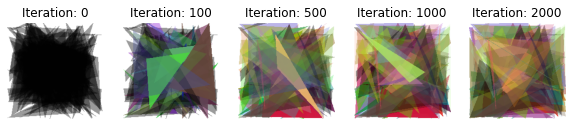

In [ ]:
# Plot some organisms
fig, ax = plt.subplots(1,5, figsize=(10,3))

for i,it in enumerate([0,100,500,1000,2000]):
    image_path = "output_images/hillclimb_" + str(it) + ".png"
    img = Image.open(image_path).convert("RGB")
    ax[i].imshow(img)
    ax[i].set_title("Iteration: " + str(it))
    ax[i].imshow(img)
    ax[i].axis('off')

From the last images we can recognise how some areas such as the hair and face start to appear. We are still quite far away from the target but the evolution goes in the clear direction. Using the information returned as a data frame we can plot a nice line chart with the fitness increasing over time, which provides a much more detailed sense of the evolution path.

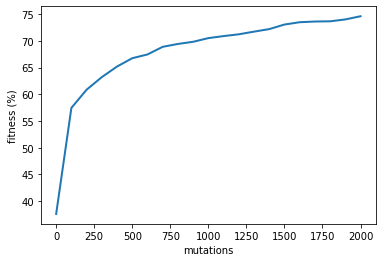

In [ ]:
plt.xlabel("mutations")
plt.ylabel("fitness (%)")
plt.plot(df["mutations"], df["fitness"], '-', linewidth=2)

Observe how different is the impact of the initial mutations with respect to the latest ones. At the beginning the fitness increases very quickly, but as we approach to the end of the probability to encounter beneficial mutations reduces dramatically and the curve starts saturating. This also highlights one of the issues of Hill Climbing algorithm; the importance of initial mutations.

<div class="alert alert-block alert-info"><b>Exercise 2:</b><br> Implement the two other mutation types, "soft" and "medium", as explained below:<br><br><u>Soft mutation:</u> This  mutation consist in modifying by a small delta (small amount) either one coordinate of one polygon's vertex or one of the RGBA channels from one polygon's colour.<br><u>Medium mutation:</u> Changing the colour and one of the vertices as in the hard mutation, but picking only one of the two options at a time.<br><br>Finally, run three difference instances of the Hill Climbing algorithm starting from the same random collection but using a different mutation type. Compare the performance curves.<br><br><i>Hint: The soft mutation is not as easy to implement as it seems. For the delta value consider a random integer from -10 to 10, making sure the resulting value does not fall outside the size of the of the canvas when changing vertices or is always within 0 and 255 when changing RGBA channels. Additionally, remember that the tuples are immutable, so you cannot modify the coordinates of a vector or change the value of an RGBA channel. Instead, you need to convert the value into a list, modify it, then convert it back to tuple and replace it with the original.</i></div>

In [ ]:
### EXERCISE 2 SOLUTION ###


## Genetic Algorithms
---

We have seen above how the hill climbing algorithm can well be a good way to reproduce a painting using polygons if we give it enough time. However, one of the problems of this that is too dependant on the path history and tends to find [local optimum solutions](https://en.wikipedia.org/wiki/Local_optimum) but can struggle a lot to find a global solution. For example, having several big polygons at the bottom will help to quickly increase the fitness at the beginning. But, as the algorithm approaches late stages, where big changes are likely to reduce the fitness and fine tuning becomes more important, those big initial polygons might suppose a burden. Especially considering that all the rest have been built on top of those. Some changes on them might be necessary to reach high scores for fitness scores, but at the same time any small change in them would immediately reduce the score. Assuming that we perform only one mutation at a time, the situation could be stuck.

Genetic algorithms, inspired by the Darwinian ideas of [natural selection](https://en.wikipedia.org/wiki/Natural_selection), overcome this problem by making a whole population "evolve" rather than just one single organism. This way, a diverse initial population ensures the best candidate would not be constrained to one single evolution path and the parameter exploration can take place from multiple fronts reducing the likelihood to fall into a local maxima trap. The different organisms of the population "mate" combining their information and generating new children. The organisms with highest fitness scores are more likely to reproduce, which promotes the combinations that are closer to the target.

In our case, a collection of polygons is considered an organism and all their values for the polygons' vertices and colours represent the genes of its DNA. Thus, a population of organisms would be a list of `Npop` organisms. We can easily create a function `create_pop()` that generates a population of those with random values.

(-0.5, 199.5, 199.5, -0.5)

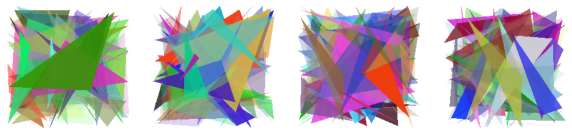

In [ ]:
def create_pop(Npop, N, size, colour_init="black", alpha_init=100):
    """
    Creates a population of organisms.

    Each organism has N triangles randomly initialised.
    """

    pop=[]
    for i in range(Npop):
        pop.append(random_triangles(N,size, colour=colour_init, alpha=alpha_init))

    return(pop)

pop = create_pop(Npop=20,N=100,size=(200,200), colour_init="random", alpha_init="random")

# Plot some organisms
fig, ax = plt.subplots(1,4, figsize=(10,3))
ax[0].imshow(draw(pop[0],size=(200,200)));
ax[0].axis('off')
ax[1].imshow(draw(pop[1],size=(200,200)));
ax[1].axis('off')
ax[2].imshow(draw(pop[2],size=(200,200)));
ax[2].axis('off')
ax[3].imshow(draw(pop[3],size=(200,200)));
ax[3].axis('off')

We can see above a sample of different organisms in our population. Each of them has a fitness value associated to it. We have already seen above how we can calculate it, but it's much more convenient to create a function that computes the fitness of each organism of the population.

In [ ]:
def pop_fitness(pop, target):
    """
    Calculates the fitness of each member of a population.
    """

    size = target.size
    # Compute maximum pixel difference for this target
    maxdiff = max_pixel_difference(target)

    # Initialise an empty vector
    fitvec = []

    for org in pop:
        img = draw(org,size)
        diff = pixel_difference(img,target)
        fitness = (1 - diff / maxdiff) * 100
        fitvec.append(fitness)

    return(fitvec)

popfit = pop_fitness(pop,target)
popfit[:4]

[47.47725154723963, 42.00752491374051, 45.4370361047005, 41.85237134210771]

The key step of the evolutionary algorithm is the reproduction of their organisms. In this step two organisms combine their gene sequences, represented their coloured polygons, and generate a new organism with part of both parents. The technical term for this in genetic algorithms jargon is called [crossover](https://en.wikipedia.org/wiki/Crossover_(genetic_algorithm)). We can create a function that performs this given two organisms selected from the population. The output will be two children organisms with some genes of each parent. The function randomly defines a crossover point cutting each parent's genes in two parts. The first children's DNA will correspond to first part of the first parent's DNA and the second part of the second parent's DNA, while the second's children DNA will be the opposite.

![title](https://github.com/mariogutierrezroig/Teaching-Notebooks/blob/main/Evolutionary_Algorithms/crossover_point.png?raw=1)

Also, during this process a mutation can occur with a certain probability `pmut`. If this happens we will use the `mutation()` function already implemented over the children's DNA.

(-0.5, 199.5, 199.5, -0.5)

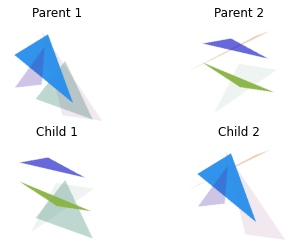

In [ ]:
def crossover(parent1, parent2, size, pmut=0.1, mtype="hard"):
    """
    Generates 2 children from 2 parent's DNA.
    """
    # define crossover point (excluding both ends)
    cp = np.random.randint(1,len(parent1) - 1)

    # Cut parent1 DNA in halves
    dna_11 = parent1[:cp]
    dna_12 = parent1[cp:]

    dna_21 = parent2[:cp]
    dna_22 = parent2[cp:]

    # merge the pieces of dna
    child1 = dna_11 + dna_22
    child2 = dna_21 + dna_12

    # mutate childrens' dna with certain probability
    if np.random.uniform(0, 1) < pmut:
        child1 = mutation(child1,size,mtype)

    if np.random.uniform(0, 1) < pmut:
        child2 = mutation(child2,size,mtype)

    return(child1,child2)

# Create populatio of 4 organisms with 4 triangles
pop = create_pop(Npop=2,N=4,size=(200,200), colour_init="random", alpha_init="random")
child1,child2 = crossover(pop[0], pop[1], (200,200), pmut=0, mtype="hard")

# Plot 2 parents and 2 childs
fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0,0].imshow(draw(pop[0],size=(200,200)));
ax[0,0].set_title("Parent 1")
ax[0,0].axis('off')
ax[0,1].imshow(draw(pop[1],size=(200,200)));
ax[0,1].set_title("Parent 2")
ax[0,1].axis('off')
ax[1,0].imshow(draw(child1,size=(200,200)));
ax[1,0].set_title("Child 1")
ax[1,0].axis('off')
ax[1,1].imshow(draw(child2,size=(200,200)));
ax[1,1].set_title("Child 2")
ax[1,1].axis('off')

If we create a population with just a few triangles and set the mutation probability to 0 (no mutations), we can clearly see which childrens' triangles come from which parents' triangles. If you slightly increase the value for the mutation probability, then you'll see new triangles appearing. Check it out!

One important issue to resolve now is the way we select the two parents, who gets the chance to reproduce. Although there are many ways to select two individuals from the population we want to make the fittest more likely to be selected. One trick to implement that is by using its fitness as a probability weight. Imagine that we have four organisms A,B,C and D with fitness values of 20%, 40%, 60% and 80%. The idea is to choose one of these letters at random but with different probabilities. Thus, D would be four times more likely two be selected than A and two times more likely than B. The function `choice()` from the `random` library allows to do that:

In [ ]:
letter_pop = ["A","B","C","D"]
letter_fit = np.array([20,40,60,80])
# Compute the normalised weights
letter_weights = letter_fit / letter_fit.sum()
randchoices = np.random.choice(letter_pop, size=50, p=letter_weights)
randchoices

array(['C', 'C', 'D', 'C', 'C', 'C', 'C', 'D', 'D', 'C', 'B', 'B', 'C',
       'D', 'D', 'B', 'C', 'D', 'D', 'D', 'D', 'C', 'D', 'D', 'A', 'C',
       'B', 'D', 'D', 'D', 'A', 'A', 'B', 'D', 'B', 'A', 'B', 'B', 'D',
       'C', 'C', 'B', 'D', 'B', 'B', 'B', 'D', 'C', 'C', 'A'], dtype='<U1')

As you can see, from the sample above the frequency of each letter is proportional to their fitness values. In our case, however we need to select couples of different parents, which is something that we can do one couple at a time with `size=2` and `replace=FALSE`.

Creating a whole new generation will consist in selecting `Npop/2` couples and performing the crossover, since each couple produces two children. We can put all that in a function `new_generation()` that returns an entirely new population.

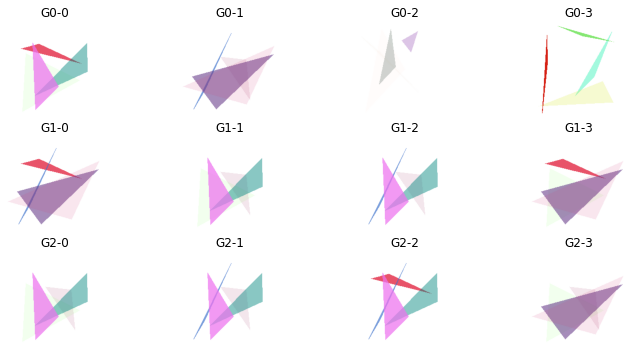

In [ ]:
def new_generation(pop, fitness, size, pmut=0.1, mtype="hard"):
    """
    Creates a new generation.
    """

    newpop = []
    Npop = len(pop)

    # Compute the weights from fitness vector
    weights = np.array(fitness) / np.array(fitness).sum()

    for i in range(int(Npop/2)):
        # Select the indexes for the parents according to their weights
        p1ix,p2ix = np.random.choice(np.arange(len(weights)), size=2, p=weights, replace=False)
        # Perform the crossover
        child1,child2 = crossover(pop[p1ix], pop[p2ix], size=size, pmut=pmut, mtype=mtype)
        # Append the two children to the newpop
        newpop.append(child1)
        newpop.append(child2)

    return(newpop)

gen0 = create_pop(Npop=4,N=4,size=(200,200), colour_init="random", alpha_init="random")
# Fake fitness vector
fitness = [91, 65, 37, 5]

gen1 = new_generation(gen0, fitness, size=(200,200), pmut=0, mtype="hard")
gen2 = new_generation(gen1, fitness, size=(200,200), pmut=0, mtype="hard")
# Plot 3 generations
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(12,6))
# Plot Gen 0
for i,pop in enumerate([gen0,gen1,gen2]):
    for j in range(4):
        ax[i,j].imshow(draw(pop[j],size=(200,200)));
        ax[i,j].axis('off')
        ax[i,j].set_title('G' + str(i) + '-' + str(j))



Above, you have an example of three generations of a population of four organisms with four genes (triangles) in its DNA. Notice how there are genes that disappear while others survive and reproduce. This is governed by a combination of chance and the fitness vector, which in this case is does not depend on a target pictures but instead on arbitrary values that happen to favour organisms with lower index. Thus, the probability to see the triangles of the top left organisms in the bottom row are higher.

The whole process can be coded into a function `genetic_triangle_painting()` that uses all functions shown above, therefore it requires all their parameters to be input as well. The general structure is quite simple and similar to the `triangle_painting_hill_climbing()` function. It starts by computing the maximum pixel difference and generatinc an initial random population. Immediately after we calculate the fitness of this population. Then, all the evolution will happen inside a `for` loop for `maxgen` iterations. In each iteration we create a new population from the old one using the `new_generation()` function, then we compute the fitness for that new generation. Every certain number of rounds we compile information and save the best candidate image into the indicated directory. Finally, we create a data frame with all the information, wich is the object we return outside the function.

In [ ]:
import pandas as pd

def genetic_triangle_painting(target, Npop, Ntri=100, maxgen=10, every=20, pmut=0.1, mtype="hard", colour_init="random", alpha_init="random", logs=True, outdir="output_images"):
    """
    Runs the genetic algorithm to reproduce the target picture using triangles.
    """

    size = target.size
    # Compute maximum pixel difference for this target
    maxdiff = max_pixel_difference(target)

    # Create initial population (Generation 0)
    pop = create_pop(Npop=Npop, N=Ntri, size=size, colour_init=colour_init, alpha_init=alpha_init)
    # Compute the fitness
    fitness = pop_fitness(pop,target)

    info = []

    for i in range(maxgen):
        # store information every x rounds
        if i%every == 0:
            maxfit = max(fitness)
            avgfit = np.mean(fitness)
            best_idx = np.argmax(fitness)
            best = pop[best_idx]
            best_img = draw(best, size=size)
            outpath = outdir + "/generation_" + str(i) + ".png"
            best_img.save(outpath)
            info.append([i, maxfit, avgfit, outpath])
            if logs==True:
                # Print on screen
                print("Generation: " + str(i) + "    Max. Fitness: " + str(np.round(maxfit,2)) + "%    Avg. Fitness: " + str(np.round(avgfit,2)) + "%")

        # Create next generation
        newpop = new_generation(pop, fitness, size=size, pmut=pmut, mtype=mtype)
        # Compute the fitness
        fitness = pop_fitness(newpop,target)

        pop = newpop

    dfout = pd.DataFrame(info, columns=["generation", "max_fitness", "avg_fitness", "outpath"])
    return(dfout)

df = genetic_triangle_painting(target, 50, Ntri=100, maxgen=1001, every=50, pmut=0.1, mtype="hard", colour_init="black", alpha_init=100, logs=True, outdir="output_images")

Generation: 0    Max. Fitness: 44.97%    Avg. Fitness: 38.03%
Generation: 50    Max. Fitness: 48.78%    Avg. Fitness: 44.27%
Generation: 100    Max. Fitness: 53.54%    Avg. Fitness: 50.43%
Generation: 150    Max. Fitness: 56.79%    Avg. Fitness: 53.4%
Generation: 200    Max. Fitness: 56.71%    Avg. Fitness: 54.29%
Generation: 250    Max. Fitness: 59.36%    Avg. Fitness: 54.53%
Generation: 300    Max. Fitness: 57.57%    Avg. Fitness: 56.44%
Generation: 350    Max. Fitness: 56.55%    Avg. Fitness: 55.4%
Generation: 400    Max. Fitness: 57.4%    Avg. Fitness: 55.16%
Generation: 450    Max. Fitness: 57.41%    Avg. Fitness: 55.22%
Generation: 500    Max. Fitness: 56.16%    Avg. Fitness: 53.82%
Generation: 550    Max. Fitness: 56.39%    Avg. Fitness: 53.84%
Generation: 600    Max. Fitness: 57.25%    Avg. Fitness: 54.51%
Generation: 650    Max. Fitness: 56.35%    Avg. Fitness: 53.94%
Generation: 700    Max. Fitness: 56.18%    Avg. Fitness: 54.91%
Generation: 750    Max. Fitness: 57.2%    Avg.

The execution of this program can take very long, especially as we increase the population and the number of generations. Let's have a look to the performance by plotting the line chart of both best candidate fitness and population average fitness.

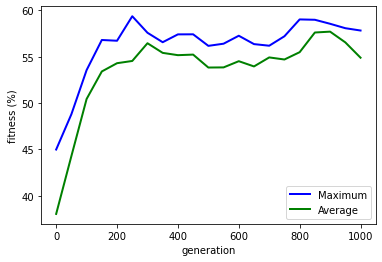

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("generation")
ax.set_ylabel("fitness (%)")
ax.plot(df["generation"], df["max_fitness"], '-', linewidth=2, color="blue", label="Maximum")
ax.plot(df["generation"], df["avg_fitness"], '-', linewidth=2, color="green", label="Average")
ax.legend(loc=4)

The performance for this particular case is not as good as hill climbing algorithm. First of all, one stark difference is the final fitness reached. Even if more mutations are performed in total (total mutations = `Npop` x `pmut` x `maxgen`), the result is well below the hill climbing algorithm. Another important difference is the fitness not increasing in a monotonic fashion. This is partially good, since we avoid the local maxima trap, but it also makes the convergence very slow.

Genetic algorithms are indeed slow, mainly because make evolve a whole population rather than once single organism. This also makes them computationally expensive. There is also the challenge of coming up with a right set of parameters. For example, if the mutation rate is very high the population cannot keep up with so many changes. Similarly, the size of the population is also a key parameter that controls the initial variety of possible solutions. Correct setting of the parameters depends on the specific problem we are trying to solve. Finding it, it's not usally easy and requires much exploration. [Metaheuristics](https://en.wikipedia.org/wiki/Metaheuristic) is one of the possible procedures that one can try.

<div class="alert alert-block alert-info"><b>Exercise 3:</b><br> In the current example, the entire next generation is created by the crossover process. However, one common feature in genetic algorithms is to define a crossover probability "pcross" that controls the probability to perform a crossover process between two partners and generate two new offspring for the next generation. The rest of the population of the new generation would be organisms that have survived, hence with copies the exact DNA. Modify the next_generation() function to implement this feature.</div>

In [ ]:
### EXERCISE 3 SOLUTION ###


---
<div style="text-align: right ;font-size: small; color: gray"> Notebook by <a href="http://mariogutierrezroig.net">Mario Gutiérrez-Roig</a>, Lecturer in Data Science and Statistics at the University of Essex <a href="http://creativecommons.org/licenses/by-sa/4.0/" rel="license"><img src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" alt="Licencia de Creative Commons" hspace="10" align="right"></a></div>